## 1. Gerekli Kütüphanelerin İçe Aktarılması ve CSV Dosyasını Okuma

In [50]:
# Veri analizi ve görselleştirme için gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium # Haritalandırma için Folium kütüphanesi

# Makine öğrenimi modelleri ve performans metrikleri için gerekli kütüphaneler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#Global Weather veri seti
file_path = 'GlobalWeatherRepository.csv'

# CSV dosyasını okuyup bir DataFrame'e yükleyelim
df = pd.read_csv(file_path)
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


## 2. Eksik Verileri Simüle Etme ve Analiz Etme

In [52]:
# Daha karmaşık bir eksik veri dağılımı oluşturmak için birden fazla sütuna eksik veri ekleyelim

np.random.seed(42)  # Sabit seed ile rastgeleliği kontrol edelim (tekrar üretilebilir sonuçlar için)

# Eksik veri oranını belirleyelim (%5 ile %15 arasında)
missing_ratios = {'temperature_celsius': 0.1, 
                  'air_quality_PM2.5': 0.15, 
                  'humidity': 0.05, 
                  'precip_mm': 0.08, 
                  'air_quality_Ozone': 0.12}

# Her sütunda rastgele eksik veriler ekleyelim
for column, ratio in missing_ratios.items():
    missing_indices = np.random.choice(df.index, size=int(ratio * len(df)), replace=False)
    df.loc[missing_indices, column] = np.nan

# Eksik verilerin oranlarını tekrar kontrol edelim
missing_data_complex = df.isnull().sum()
missing_percentage_complex = (missing_data_complex / len(df)) * 100

missing_df_complex = pd.DataFrame({'Missing Values': missing_data_complex, 'Percentage': missing_percentage_complex}) # Eksik veri oranlarını DataFrame olarak gösterelim
missing_df_complex.sort_values(by='Percentage', ascending=False, inplace=True)

# Eksik verilerin durumunu gösterelim
missing_df_complex.head(10)

,Missing Values,Percentage
air_quality_PM2.5,5324,14.997606
air_quality_Ozone,4259,11.997521
temperature_celsius,3549,9.997465
precip_mm,2839,7.997408
humidity,1774,4.997324
air_quality_Sulphur_dioxide,0,0.000000
uv_index,0,0.000000
gust_mph,0,0.000000
gust_kph,0,0.000000
air_quality_Carbon_Monoxide,0,0.000000


## 3. Eksik Verileri Doldurma

In [53]:
# Eksik verileri ortalama veya medyan ile doldurma


df['temperature_celsius'] = df['temperature_celsius'].fillna(df['temperature_celsius'].mean())
df['air_quality_PM2.5'] = df['air_quality_PM2.5'].fillna(df['air_quality_PM2.5'].mean())
df['humidity'] = df['humidity'].fillna(df['humidity'].median())
df['precip_mm'] = df['precip_mm'].fillna(df['precip_mm'].median())
df['air_quality_Ozone'] = df['air_quality_Ozone'].fillna(df['air_quality_Ozone'].median())

# Eksik verilerin tekrar kontrolü
missing_data_after_complex = df.isnull().sum()
missing_percentage_after_complex = (missing_data_after_complex / len(df)) * 100
missing_df_after_complex = pd.DataFrame({'Missing Values': missing_data_after_complex, 'Percentage': missing_percentage_after_complex})
missing_df_after_complex.sort_values(by='Percentage', ascending=False, inplace=True)

# Eksik veriler doldurulduktan sonraki durumu gösterelim
missing_df_after_complex.head(10)

,Missing Values,Percentage
country,0,0.0
feels_like_fahrenheit,0,0.0
visibility_miles,0,0.0
uv_index,0,0.0
gust_mph,0,0.0
gust_kph,0,0.0
air_quality_Carbon_Monoxide,0,0.0
air_quality_Ozone,0,0.0
air_quality_Nitrogen_dioxide,0,0.0
air_quality_Sulphur_dioxide,0,0.0


## 4. Korelasyon Analizi 

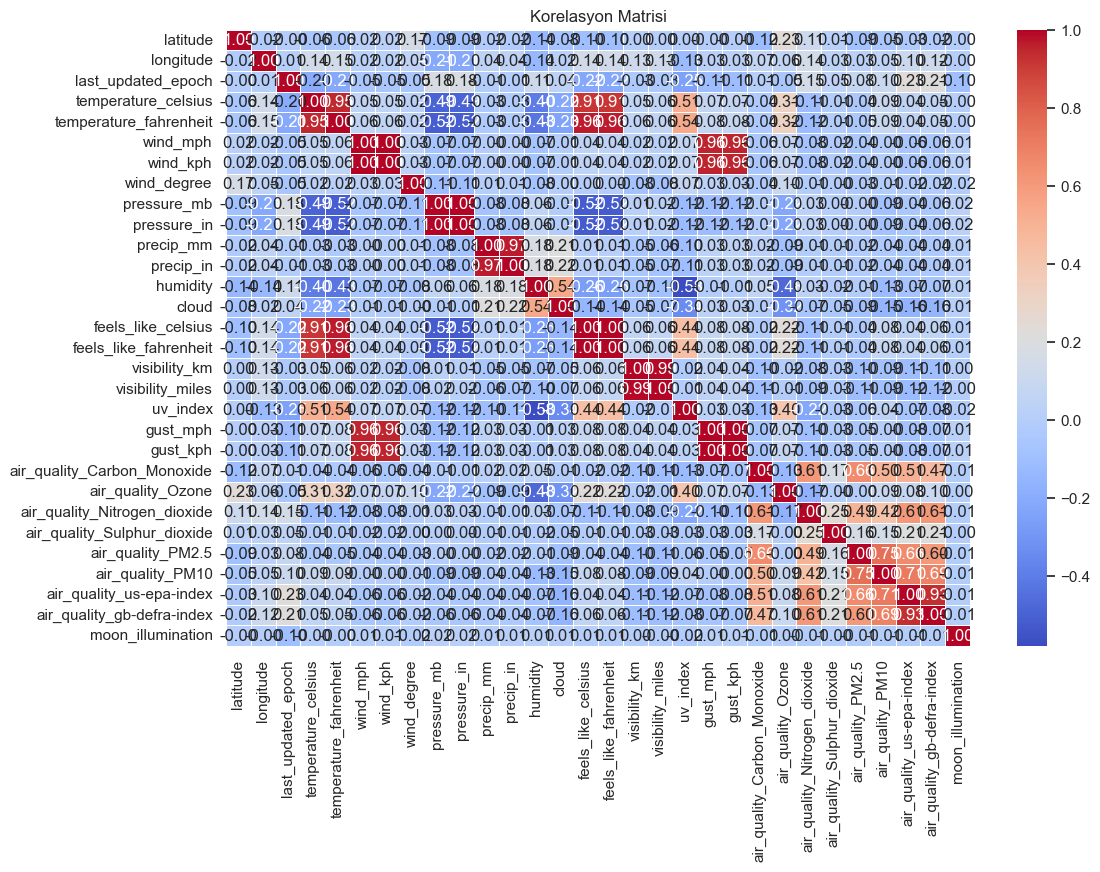

In [54]:
# Veri setindeki sayısal sütunlar arasındaki ilişkiyi analiz etmek için korelasyon matrisi hesaplanır.
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Korelasyon Matrisi")
plt.show()

## 5. Sıcaklık ve PM2.5 İlişkisi Analizi

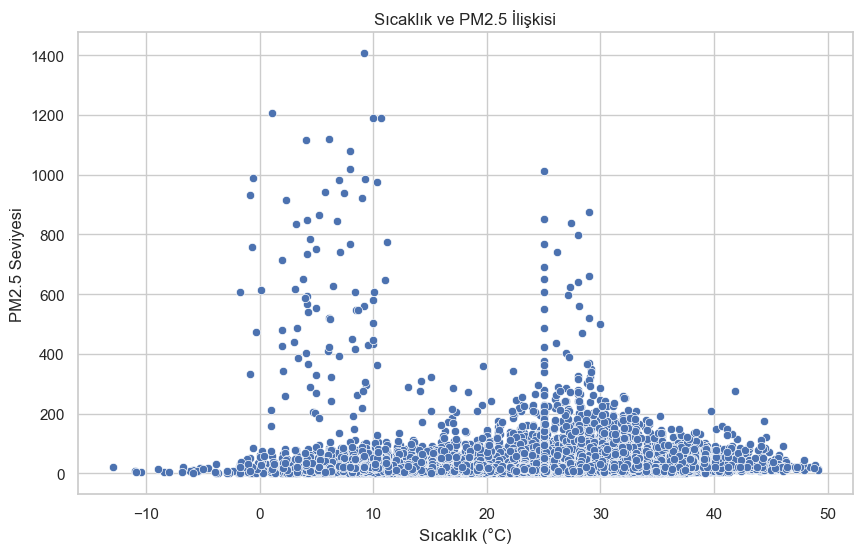

In [55]:
# Sıcaklık ve PM2.5 Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temperature_celsius', y='air_quality_PM2.5')
plt.title("Sıcaklık ve PM2.5 İlişkisi")
plt.xlabel("Sıcaklık (°C)")
plt.ylabel("PM2.5 Seviyesi")
plt.grid(True)
plt.show()

## 6. Zaman Serisi Analizi

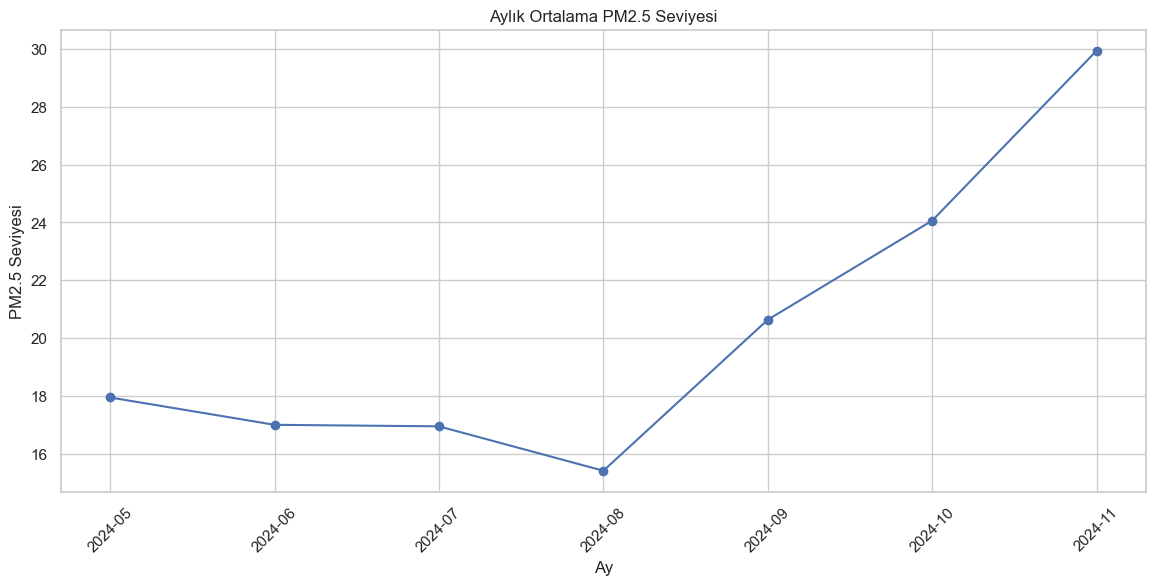

In [56]:
# Tarih sütunları datetime formatına çevrilir ve aylık ortalama PM2.5 değerleri hesaplanır.
df['last_updated'] = pd.to_datetime(df['last_updated'])
df['month'] = df['last_updated'].dt.to_period('M')
monthly_avg_pm25 = df.groupby('month')['air_quality_PM2.5'].mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_pm25.index.astype(str), monthly_avg_pm25, marker='o')
plt.title("Aylık Ortalama PM2.5 Seviyesi")
plt.xlabel("Ay")
plt.ylabel("PM2.5 Seviyesi")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 7. Makine Öğrenimi ile PM2.5 Tahmini


In [57]:
# 1. Özellikleri Belirleme
# Burada, veri setinden sayısal özellikler seçilir ve hedef değişken olan PM2.5 değeri çıkarılır.
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
features = df[numerical_columns].drop(['air_quality_PM2.5'], axis=1)
target = df['air_quality_PM2.5']

# StandartScaler, tüm özellikleri aynı ölçekte normalize ederek modelin daha tutarlı çalışmasını sağlar.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# SelectKBest, hedef değişkenle en çok ilişkili olan 5 özelliği seçmek için kullanılır.
selector = SelectKBest(f_regression, k=5)
features_selected = selector.fit_transform(features_scaled, target)

# Eğitim ve test verisini ayırma
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Modeli eğitme
# Parametre aralığını belirleyelim
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'random_state': [42]
}

# RandomizedSearchCV ile modeli eğitme
model = RandomForestRegressor()
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # Kaç farklı parametre kombinasyonu denenecek
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


# Performans değerlendirme
# R2 Skoru: Hedef değişken ile tahmin edilen değerler arasındaki ilişkiyi ölçer. 1'e yakın bir skor, güçlü bir ilişki olduğunu gösterir.
# MSE (Mean Squared Error): Hedef değişken ile tahmin edilen değerler arasındaki hata karelerinin ortalamasını verir. Küçük bir değer, daha iyi bir performansı ifade eder.
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2 Score: {r2}")
print(f"Mean Squared Error: {mse}")
print("\nEn iyi parametreler:", random_search.best_params_)

# Gerçek ve tahmin edilen değerleri bir DataFrame olarak oluştur
results_df = pd.DataFrame({
    'Gerçek PM2.5 Değeri': y_test,
    'Tahmin Edilen PM2.5 Değeri': y_pred
})

# İlk 10 tahmini göster
print("\n--- İlk 10 Tahmin Sonucu ---")
print(results_df.head(10))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
R2 Score: 0.9005051612410443
Mean Squared Error: 221.6099885256335

En iyi parametreler: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 124, 'random_state': 42}

--- İlk 10 Tahmin Sonucu ---
       Gerçek PM2.5 Değeri  Tahmin Edilen PM2.5 Değeri
26529            19.664607                   20.811158
11500             1.300000                    3.403897
8279              2.300000                    4.778471
34476             9.542000                   11.663567
17423            13.100000                   15.164697
734               7.500000                    9.587674
32375            63.640000                   59.591625
13608             6.900000                    8.991291
12728            19.664607                    5.797174
19407             6.600000                    6.588897


## 8. Hava Kalitesi Temizlik Süresi Hesaplama

In [59]:
# PM2.5 temizleme süresi hesaplama fonksiyonu
def calculate_cleanup_years(pm2_5_value):
    safe_pm2_5_level = 10
    reduction_rate = 0.1  # %10 azalma
    years = 0
    while pm2_5_value > safe_pm2_5_level:
        pm2_5_value -= pm2_5_value * reduction_rate
        years += 1
    return years

df['cleanup_years'] = df['air_quality_PM2.5'].apply(calculate_cleanup_years)

df[['country', 'location_name', 'air_quality_PM2.5', 'cleanup_years']].head(10)

,country,location_name,air_quality_PM2.5,cleanup_years
0,Afghanistan,Kabul,8.4,0
1,Albania,Tirana,1.1,0
2,Algeria,Algiers,10.4,1
3,Andorra,Andorra La Vella,0.7,0
4,Angola,Luanda,183.4,28
5,Antigua and Barbuda,Saint John's,1.2,0
6,Argentina,Buenos Aires,4.0,0
7,Armenia,Yerevan,0.8,0
8,Australia,Canberra,3.7,0
9,Austria,Vienna,3.7,0


## 9. Interaktif Harita Görselleştirmesi ve Üstüne Tıklanılan Noktada Öneriler

In [ ]:
# Harita merkezi olarak ortalama enlem ve boylam belirleyelim
map_center = [df['latitude'].mean(), df['longitude'].mean()]
cleanup_map = folium.Map(location=map_center, zoom_start=2)

# Renk belirleme fonksiyonu
def get_color(years):
    if years <= 5:
        return 'green'
    elif years <= 10:
        return 'orange'
    else:
        return 'red'

# Öneri fonksiyonu (PM2.5 seviyesine göre)
def get_improvement_suggestions(pm2_5_value):
    if pm2_5_value > 50:
        return "Sanayi emisyonlarını azaltın, elektrikli araçlara geçiş yapın."
    elif pm2_5_value > 20:
        return "Ağaçlandırma ve toplu taşımayı teşvik edin."
    else:
        return "Yeşil alanları koruyun, temiz enerji kaynakları kullanın."

# Şehirleri harita üzerinde işaretleyelim
for index, row in df.iterrows():
    color = get_color(row['cleanup_years'])
    suggestion = get_improvement_suggestions(row['air_quality_PM2.5'])
    popup_text = (
        f"{row['location_name']} ({row['country']})<br>"
        f"PM2.5: {row['air_quality_PM2.5']}<br>"
        f"Temizlik Süresi: {row['cleanup_years']} yıl<br>"
        f"Öneri: {suggestion}"
    )
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=7,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=popup_text
    ).add_to(cleanup_map)

# Haritayı görüntüleyelim
cleanup_map

### Haritanın Örnek Gösterimini "image.png"'den görebilirsiniz. Yüksek boyutlu bir öneri sistemi olduğu için kodu local olarak çalıştırınız. 